In [1]:
import pdb
import numpy as np
import gcp.bigquery as bq
import gcp.storage as storage
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
try:
   import cPickle as pickle
except:
   import pickle
EST_PICKLE_FILENAME = 'GradientBoostingRegressor_grid_best.pkl'

seed = 13
np.random.seed(seed)

# Put all categorical data first for easier implementation of One Hot Encoding.
fields_str = """
gap	day_in_week	weather_1_slots_ago	weather_2_slots_ago	weather_3_slots_ago	busy_time	
tj_level1_1_slots_ago	tj_level2_1_slots_ago	tj_level3_1_slots_ago	tj_level4_1_slots_ago	
tj_level1_2_slots_ago	tj_level2_2_slots_ago	tj_level3_2_slots_ago	tj_level4_2_slots_ago	
tj_level1_3_slots_ago	tj_level2_3_slots_ago	tj_level3_3_slots_ago	tj_level4_3_slots_ago	
temperature_1_slots_ago	pm25_1_slots_ago	
temperature_2_slots_ago	pm25_2_slots_ago	
temperature_3_slots_ago	pm25_3_slots_ago	
gap_1_slots_ago	sum_price_1_slots_ago	
gap_2_slots_ago	sum_price_2_slots_ago	
gap_3_slots_ago	sum_price_3_slots_ago	
f1	f11	f11_1	f11_2	f11_3	f11_4	f11_5	f11_6	f11_7	
f11_8	f13_4	f13_8	f14	f14_1	f14_10	f14_2	f14_3	f14_6	f14_8	f15	f15_1	
f15_2	f15_3	f15_4	f15_6	f15_7	f15_8	f16	f16_1	f16_10	f16_11	f16_12	f16_3	
f16_4	f16_6	f17	f17_2	f17_3	f17_4	f17_5	f19	f19_1	f19_2	f19_3	f19_4	f1_1	
f1_10	f1_11	f1_2	f1_3	f1_4	f1_5	f1_6	f1_7	f1_8	f20	f20_1	f20_2	
f20_4	f20_5	f20_6	f20_7	f20_8	f20_9	f21_1	f21_2	f22	f22_1	f22_2	f22_3	
f22_4	f22_5	f23	f23_1	f23_2	f23_3	f23_4	f23_5	f23_6	f24	f24_1	f24_2	f24_3	
f25	f25_1	f25_3	f25_7	f25_8	f25_9	f2_1	f2_10	f2_11	f2_12	f2_13	f2_2	
f2_4	f2_5	f2_6	f2_7	f2_8	f3_1	f3_2	f3_3	f4	f4_1	f4_10	f4_11	
f4_13	f4_14	f4_16	f4_17	f4_18	f4_2	f4_3	f4_5	f4_6	f4_7	f4_8	f4_9	
f5	f5_1	f5_3	f5_4	f6	f6_1	f6_2	f6_4	f7	f8	f8_1	f8_2	f8_3	f8_4	
f8_5
"""
fields = map(lambda x: x.strip(), fields_str.split('\t'))
features = fields[1:]

# Use this instead of len(features) since this variable can change
# e.g. when one hot encoding is used and/or new features are added.
n_features = len(features)

# Scorer Creation (MAPE)

In [2]:
def mape(y, predictions):
#   num_timeslots = 43
#   num_districts = 66
  if len(y.shape) == 1:
    y = np.asmatrix(y)
  if len(predictions.shape) == 1:
    predictions = np.asmatrix(predictions)
  y = y.astype(float)
  predictions = predictions.astype(float)
  return np.mean(np.absolute((y-predictions)/y))

# from keras import backend as K

# def mape(y, predictions):
#   return K.mean(K.abs(y-predictions/K.clip(K.abs(y), K.epsilon(), np.inf)), axis=-1)

mape_scorer = make_scorer(mape, greater_is_better=False)

Testing MAPE

In [3]:
from sklearn.linear_model import LogisticRegression

predictions = np.array([1.0, 2.0, 3.0, 4.0]).astype('float32')
y = np.array([1.0, 2.0, 3.0, 4.0]).astype('float32')

# Should return 0.0
print mape(y, predictions)

# Should return higher score
predictions = np.array([1.0, 2.0, 2.0, 3.0]).astype('float32')
print(mape(y, predictions))

# Should return highest score
predictions = np.array([1000.0, 22.0, 11.0, 31.0]).astype('float32')
print(mape(y, predictions))

# est = LogisticRegression()
# X = np.random.rand(10,4)
# y = X.sum(axis=1)
# est.fit(X, y)
# predictions = est.predict(X)
# print(mape(y, predictions))

0.0
0.145833333333
254.604166667


# Feature Selection

In [4]:
%%sql --module q_all

SELECT *, HASH(CAST(district_id AS STRING) +timeslot) AS hash_value,
  IF(ABS(HASH(CAST(district_id AS STRING) + timeslot)) % 2 == 1, 'True', 'False')
    AS included_in_sample, IF(timeofday_slot >= 50 AND timeofday_slot <= 53, 1, 0) AS busy_time
FROM [datalab-projects-1331:xjk_algo_comp.gaps]
WHERE gap > 0
LIMIT 80000

# The above query randomizes its outputs.

In [5]:
query = bq.Query(q_all)
tableresult = query.results()

all_data = np.zeros((tableresult.length, len(fields)))
print 'there are {} rows'.format(tableresult.length)
for rcounter, row in enumerate(tableresult):
  for fcounter, field in enumerate(fields):
    all_data[rcounter, fcounter] = row[field]
  if rcounter % 5000 == 0:
    print 'processed {} rows'.format(rcounter)
all_data_original = np.copy(all_data)

there are 80000 rows
processed 0 rows
processed 5000 rows
processed 10000 rows
processed 15000 rows
processed 20000 rows
processed 25000 rows
processed 30000 rows
processed 35000 rows
processed 40000 rows
processed 45000 rows
processed 50000 rows
processed 55000 rows
processed 60000 rows
processed 65000 rows
processed 70000 rows
processed 75000 rows


In [6]:
# This chunk does further wrangling to dataset to produce training and test sets.

# Useful code to check NaN and Inf values. This is needed since these values would
# cause "Input contains NaN, infinity or a value too large for dtype('float32')
# errors when left unchecked.
print "Checkinf for NaN and Inf"
print "np.nan=", np.where(np.isnan(all_data_original))
print "is.inf=", np.where(np.isinf(all_data_original))
print "np.max=", np.max(abs(all_data_original))

# Impute all NaN with numbers (not sure what to replace inf yet)
all_data[np.isnan(all_data_original)] = 0
# all_data[np.isinf(all_data)] = 0

# See that NaN and Inf values replaced
print "Checkinf for NaN and Inf"
print "np.nan=", np.where(np.isnan(all_data))
print "is.inf=", np.where(np.isinf(all_data))
print "np.max=", np.max(abs(all_data))

# Split the data into train and test sets.
data_size = all_data.shape[0]
training_size = data_size * 80/100
indices = np.random.permutation(data_size)
training_idx, test_idx = indices[:training_size], indices[training_size:]
all_data_train, all_data_test = all_data[training_idx,:], all_data[test_idx,:]

data_train = all_data_train[:,1:]
targets_train = all_data_train[:,0]
data_test = all_data_test[:,1:]
targets_test = all_data_test[:,0]
data_train_original = np.copy(data_train)
data_test_original = np.copy(data_test)

Checkinf for NaN and Inf
np.nan= (array([    5,     5,    19, ..., 79999, 79999, 79999]), array([24, 25, 24, ..., 15, 16, 17]))
is.inf= (array([], dtype=int64), array([], dtype=int64))
np.max= nan
Checkinf for NaN and Inf
np.nan= (array([], dtype=int64), array([], dtype=int64))
is.inf= (array([], dtype=int64), array([], dtype=int64))
np.max= 461563.0


# Data Exploration - Find NaN values

In [7]:
# This is how to get position of NaNs

nulls = np.isnan(all_data_original)
nullspos = np.column_stack(np.where(nulls==True))
nullspos

array([[    5,    24],
       [    5,    25],
       [   19,    24],
       ..., 
       [79999,    15],
       [79999,    16],
       [79999,    17]])

In [13]:
import pandas as pd
from operator import itemgetter
print "total data points:", (all_data_original.shape[0] * all_data_original.shape[1])
print "number of missing values:", nullspos.shape[0]
print(np.unique(nullspos[:,1]).tolist())
missing_features = itemgetter(*np.unique(nullspos[:,1]).tolist())(fields)
print(missing_features)
missing_features_table = pd.DataFrame(columns=['id', 'field', 'missing data points'])
for id, field in enumerate(fields):
  missing_features_table.append({'id': id, 'field': field, 'missing data points': 0}, ignore_index=True)
missing_features_table

total data points: 13120000
number of missing values: 108553
[2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
('weather_1_slots_ago', 'weather_2_slots_ago', 'weather_3_slots_ago', 'tj_level1_1_slots_ago', 'tj_level2_1_slots_ago', 'tj_level3_1_slots_ago', 'tj_level4_1_slots_ago', 'tj_level1_2_slots_ago', 'tj_level2_2_slots_ago', 'tj_level3_2_slots_ago', 'tj_level4_2_slots_ago', 'tj_level1_3_slots_ago', 'tj_level2_3_slots_ago', 'tj_level3_3_slots_ago', 'tj_level4_3_slots_ago', 'temperature_1_slots_ago', 'pm25_1_slots_ago', 'temperature_2_slots_ago', 'pm25_2_slots_ago', 'temperature_3_slots_ago', 'pm25_3_slots_ago', 'gap_1_slots_ago', 'sum_price_1_slots_ago', 'gap_2_slots_ago', 'sum_price_2_slots_ago', 'gap_3_slots_ago', 'sum_price_3_slots_ago')


TypeError: Can only append a Series if ignore_index=True or if the Series has a name

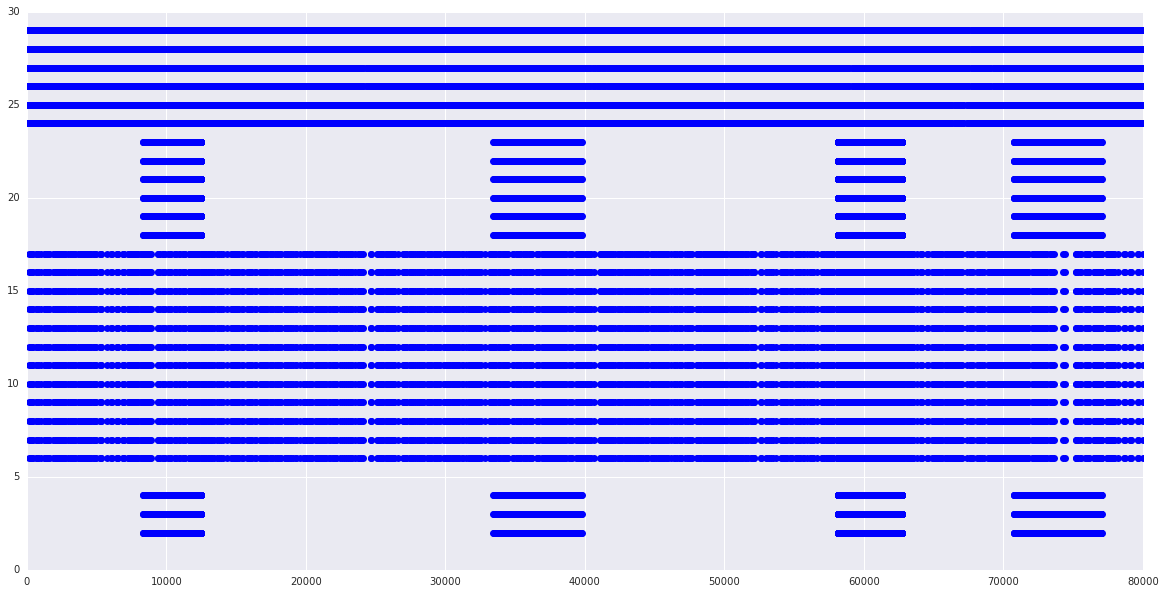

In [9]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
_ = plt.plot(nullspos[:,0], nullspos[:,1], 'bo')

In [ ]:
print(all_data_original.shape)
print(len(features))

In [ ]:
all_data_original[5,24]

In [ ]:
tableresult[5]

In [ ]:
%%sql
SELECT sum_price_1_slots_ago FROM [datalab-projects-1331:xjk_algo_comp.gaps]
WHERE IS_NAN(sum_price_1_slots_ago) = true

# Continue to One Hot Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# one_hot = OneHotEncoder(categorical_features=[0, 1, 14, 17, 20], n_values='auto')
one_hot = OneHotEncoder(categorical_features=[0, 1, 2, 3], sparse=False)
one_hot.fit(data_train)

In [ ]:
one_hot.n_values_

In [ ]:
one_hot.feature_indices_

# Building and Testing Algorithm(s)

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.sparse import coo_matrix, hstack

class CustomRegressor(BaseEstimator, RegressorMixin):
  def __init__(self):
    pass

  def fit(self, X, y):
#     self.classes_, indices = np.unique(["foo", "bar", "foo"],
#                                     return_inverse=True)
#     self.majority_ = np.argmax(np.bincount(indices))
    return self

  def predict(self, X):
    # 56: gap_1_slots_ago
    # 58: gap_2_slots_ago
    # 60: gap_3_slots_ago
#     X = X.tocsr()
#     v1 = coo_matrix(np.asmatrix(np.ones(X.shape[0])).T)
    v1 = np.asmatrix(np.ones(X.shape[0]))
    v2 = np.asmatrix((X[:, 23]*0.65+X[:, 25]*0.25+X[:, 27]*0.15)/2)
    predictions = np.asarray(np.concatenate((v1, v2), axis=0).max(axis=0))
    
    return predictions
  
custom_est = CustomRegressor()
custom_est.fit(data_train_original, data_test_original)
custom_predictions = custom_est.predict(data_test_original)
print(mape(targets_test, custom_predictions))

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import Imputer, OneHotEncoder
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA

steps = [
#   ('one_hot', OneHotEncoder(categorical_features=[0, 1, 2, 3], sparse=False)),
#   ('impute', Imputer(0)),
#   ('feature_selection', SelectKBest(f_classif)),
#   ('pca', PCA(n_components=120)),
  
  ('impute', Imputer()),
  # Remember that gap, the first variable, is removed, thus categorical_features
  # should start at index 0.
  ('one_hot', OneHotEncoder(categorical_features=[0, 1, 2, 3], sparse=False,
                           n_values=[7, 10, 10, 10])),
  ('scale', StandardScaler()),
  ('estimate', GradientBoostingRegressor())

]

est = Pipeline(steps)

params = {
#   'one_hot__n_values': [7, 10, 20],
#   "feature_selection__k": [i for i in range(1, n_features - 1)]
#   'estimate__max_features': [i for i in range(110, n_features, 10)],
  'estimate__learning_rate': [0.1, 0.5, 1, 10],
  'estimate__n_estimators': [i for i in range(110, n_features, 20)],
#   'estimate__loss': ['linear', 'square', 'exponential']
}
# cross_validation_iter = StratifiedShuffleSplit(y=targets_train, test_size=0.3,
#                                                random_state=RANDOM_STATE, n_iter=10)
# search_params = RandomizedSearchCV(
#   estimator=est,
#   param_distributions=params,
#   cv=5,
#   scoring=mape_scorer,
#   n_jobs=2,
#   verbose=1
# )

search_params = GridSearchCV(
  estimator=est,
  param_grid=params,
  cv=5,
  scoring=mape_scorer,
  n_jobs=5,
  verbose=3
)

search_params.fit(data_train_original, targets_train)
print(search_params.grid_scores_)
print(search_params.best_params_)
print(search_params.best_score_)
search_params.best_estimator_

In [ ]:
search_params.best_estimator_.steps

Test data's prediction MAPE score:

In [ ]:
final_est = search_params.best_estimator_
test_predictions = final_est.predict(data_test_original)
print(mape(targets_test, test_predictions))

In [ ]:
test_predictions = search_params.predict(data_test_original)
print(mape(targets_test, test_predictions))

In [ ]:
pickle.dump(final_est, open(EST_PICKLE_FILENAME, "w") )

In [ ]:
# Compare baseline with final algorithm

import pdb
import numpy as np
import gcp.bigquery as bq
import gcp.storage as storage
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.optimizers import SGD
import tensorflow as tf
import h5py
from sklearn.preprocessing import Imputer, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, Activation
import time
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt
from keras.layers import Dropout

HDF_FILENAME = 'final_model3.hdf5'
JSON_MODEL_FILENAME = 'final_model.json'


steps = [
  ('impute', Imputer()),
  # Remember that gap, the first variable, is removed, thus categorical_features
  # should start at index 0.
  ('one_hot', OneHotEncoder(categorical_features=[0, 1, 2, 3], sparse=False,
                           n_values=[7, 10, 10, 10])),
  ('scale', StandardScaler()),
#   ('pca', PCA(n_components=120)),
#   ('estimate', final_model)
]
transformer = Pipeline(steps)
data_test2 = transformer.fit_transform(data_test_original)



def mape(y, predictions):
  return K.mean(K.abs(y-predictions/K.clip(K.abs(y), K.epsilon(), np.inf)), axis=-1)

epochs = 50

def get_optimizer(epochs=50):
  learning_rate = 0.2
  decay_rate = learning_rate / epochs
  momentum = 0.8
  return SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

from keras.models import model_from_json
json_file = open(JSON_MODEL_FILENAME, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(HDF_FILENAME)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss=mape, optimizer=get_optimizer(epochs))

score = loaded_model.evaluate(data_test2, targets_test, verbose=0)
print "%s: %.2f" % (loaded_model.metrics_names[0], score)
test_predictions2 = loaded_model.predict(data_test2)
print 'sample predictions:'
print(test_predictions2[0:10])

Run "Process Final Test Data With Final Algorithm" to use pickled final algorithm against final test data to produce csv required by this competition.

# Results

Pipeline(steps=[('one_hot', OneHotEncoder(categorical_features=[0, 1, 2, 3], dtype=<type 'float'>,
       handle_unknown='error', n_values='auto', sparse=False)), ('pca', PCA(copy=True, n_components=120, whiten=False)), ('estimate', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=112,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=None,
           splitter='best'))])
           
1000 training data, Score: 0.924

Pipeline(steps=[('one_hot', OneHotEncoder(categorical_features=[0, 1, 2, 3], dtype=<type 'float'>,
       handle_unknown='error', n_values='auto', sparse=False)), ('pca', PCA(copy=True, n_components=120, whiten=False)), ('estimate', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=114,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=None,
           splitter='best'))])

5000 training data, Score: 0.992


Pipeline(steps=[('one_hot', OneHotEncoder(categorical_features=[0, 1, 2, 3], dtype=<type 'float'>,
       handle_unknown='error', n_values='auto', sparse=False)), ('pca', PCA(copy=True, n_components=120, whiten=False)), ('estimate', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=111,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=None,
           splitter='best'))])
           
20000 training data, Score: 1.001

Pipeline(steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('one_hot', OneHotEncoder(categorical_features=[0, 1, 2, 3], dtype=<type 'float'>,
       handle_unknown='error', n_values=[7, 10, 10, 10], sparse=False)), ('scale', StandardScaler(copy=True, with_mean=T...s_split=2,
           min_weight_fraction_leaf=0.0, random_state=None,
           splitter='best'))])
           
80000 training data, Score: 0.977 (submitted date 17)

[('impute',
  Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)),
 ('one_hot',
  OneHotEncoder(categorical_features=[0, 1, 2, 3], dtype=<type 'float'>,
         handle_unknown='error', n_values=[7, 10, 10, 10], sparse=False)),
 ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('estimate',
  GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.5, loss='ls',
               max_depth=3, max_features=None, max_leaf_nodes=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=190,
               random_state=None, subsample=1.0, verbose=0, warm_start=False))]
               
80000 training data, Score: 0.798